Get rid of these throughout. Just do once in preface.

In [1]:
# Load packages and check versions
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400 #high res figures
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import shap

In [2]:
from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=5000, n_features=40, n_informative=3,
    n_redundant=2, n_repeated=0, n_classes=2,
    n_clusters_per_class=3, weights=None, flip_y=0.05,
    class_sep=0.1, hypercube=True, shift=0.0,
    scale=1.0, shuffle=True, random_state=2)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = \
train_test_split(X, y, test_size=0.2, random_state=24)

In [4]:
y.mean()

0.4986

# Early stopping example
First fit the model on the training set without early stopping.

In [5]:
import xgboost as xgb
xgb_model_1 = xgb.XGBClassifier(
    n_estimators=1000,
    verbosity=1,
    use_label_encoder=False,
    objective='binary:logistic',
    learning_rate=0.3)

In [6]:
%%time
xgb_model_1.fit(X_train, y_train, eval_metric="auc", verbose=True)

CPU times: user 42 s, sys: 190 ms, total: 42.2 s
Wall time: 11 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=1)

In [7]:
val_set_pred_proba = xgb_model_1.predict_proba(X_val)[:,1]
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, val_set_pred_proba)
#0.7773798710782294

0.7773798710782294

Now with early stopping.

In [8]:
eval_set = [(X_train, y_train), (X_val, y_val)]

In [9]:
%%time
xgb_model_1.fit(X_train, y_train, eval_set=eval_set,
                eval_metric='auc',
                verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.80412	validation_1-auc:0.75223
[1]	validation_0-auc:0.84422	validation_1-auc:0.79207
[2]	validation_0-auc:0.85920	validation_1-auc:0.79278
[3]	validation_0-auc:0.86616	validation_1-auc:0.79517
[4]	validation_0-auc:0.88261	validation_1-auc:0.79659
[5]	validation_0-auc:0.88605	validation_1-auc:0.80061
[6]	validation_0-auc:0.89226	validation_1-auc:0.80224
[7]	validation_0-auc:0.89826	validation_1-auc:0.80305
[8]	validation_0-auc:0.90559	validation_1-auc:0.80095
[9]	validation_0-auc:0.91954	validation_1-auc:0.79685
[10]	validation_0-auc:0.92113	validation_1-auc:0.79608
[11]	validation_0-auc:0.92393	validation_1-auc:0.79763
[12]	validation_0-auc:0.92526	validation_1-auc:0.79842
[13]	validation_0-auc:0.92699	validation_1-auc:0.79883
[14]	validation_0-auc:0.93105	validation_1-auc:0.79716
[15]	validation_0-auc:0.94393	validation_1-auc:0.79750
[16]	validation_0-auc:0.95007	validation_1-auc:0.79431
[17]	validation_0-auc:0.95204	validation_1-auc:0.79407
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=1)

In [10]:
val_set_pred_proba_2 = xgb_model_1.predict_proba(X_val)[:,1]
roc_auc_score(y_val, val_set_pred_proba_2)
#0.8030501882609966

0.8030501882609966

This is a simple and intuitive way to reduce overfitting.

Learning rate.

In [11]:
learning_rates = np.linspace(0.01, 1, 25)
learning_rates

array([0.01   , 0.05125, 0.0925 , 0.13375, 0.175  , 0.21625, 0.2575 ,
       0.29875, 0.34   , 0.38125, 0.4225 , 0.46375, 0.505  , 0.54625,
       0.5875 , 0.62875, 0.67   , 0.71125, 0.7525 , 0.79375, 0.835  ,
       0.87625, 0.9175 , 0.95875, 1.     ])

Print progress

In [12]:
%%time
val_aucs = []
for learning_rate in learning_rates:
    xgb_model_1.set_params(**{'learning_rate':learning_rate})
    xgb_model_1.fit(X_train, y_train, eval_set=eval_set,
                    eval_metric='auc',
                    verbose=False, early_stopping_rounds=30)
    val_set_pred_proba_2 = xgb_model_1.predict_proba(X_val)[:,1]
    val_aucs.append(roc_auc_score(y_val, val_set_pred_proba_2))

CPU times: user 1min 24s, sys: 561 ms, total: 1min 25s
Wall time: 22.2 s


In [13]:
max(val_aucs)

0.8115309360232714

Text(0, 0.5, 'Validation set ROC AUC')

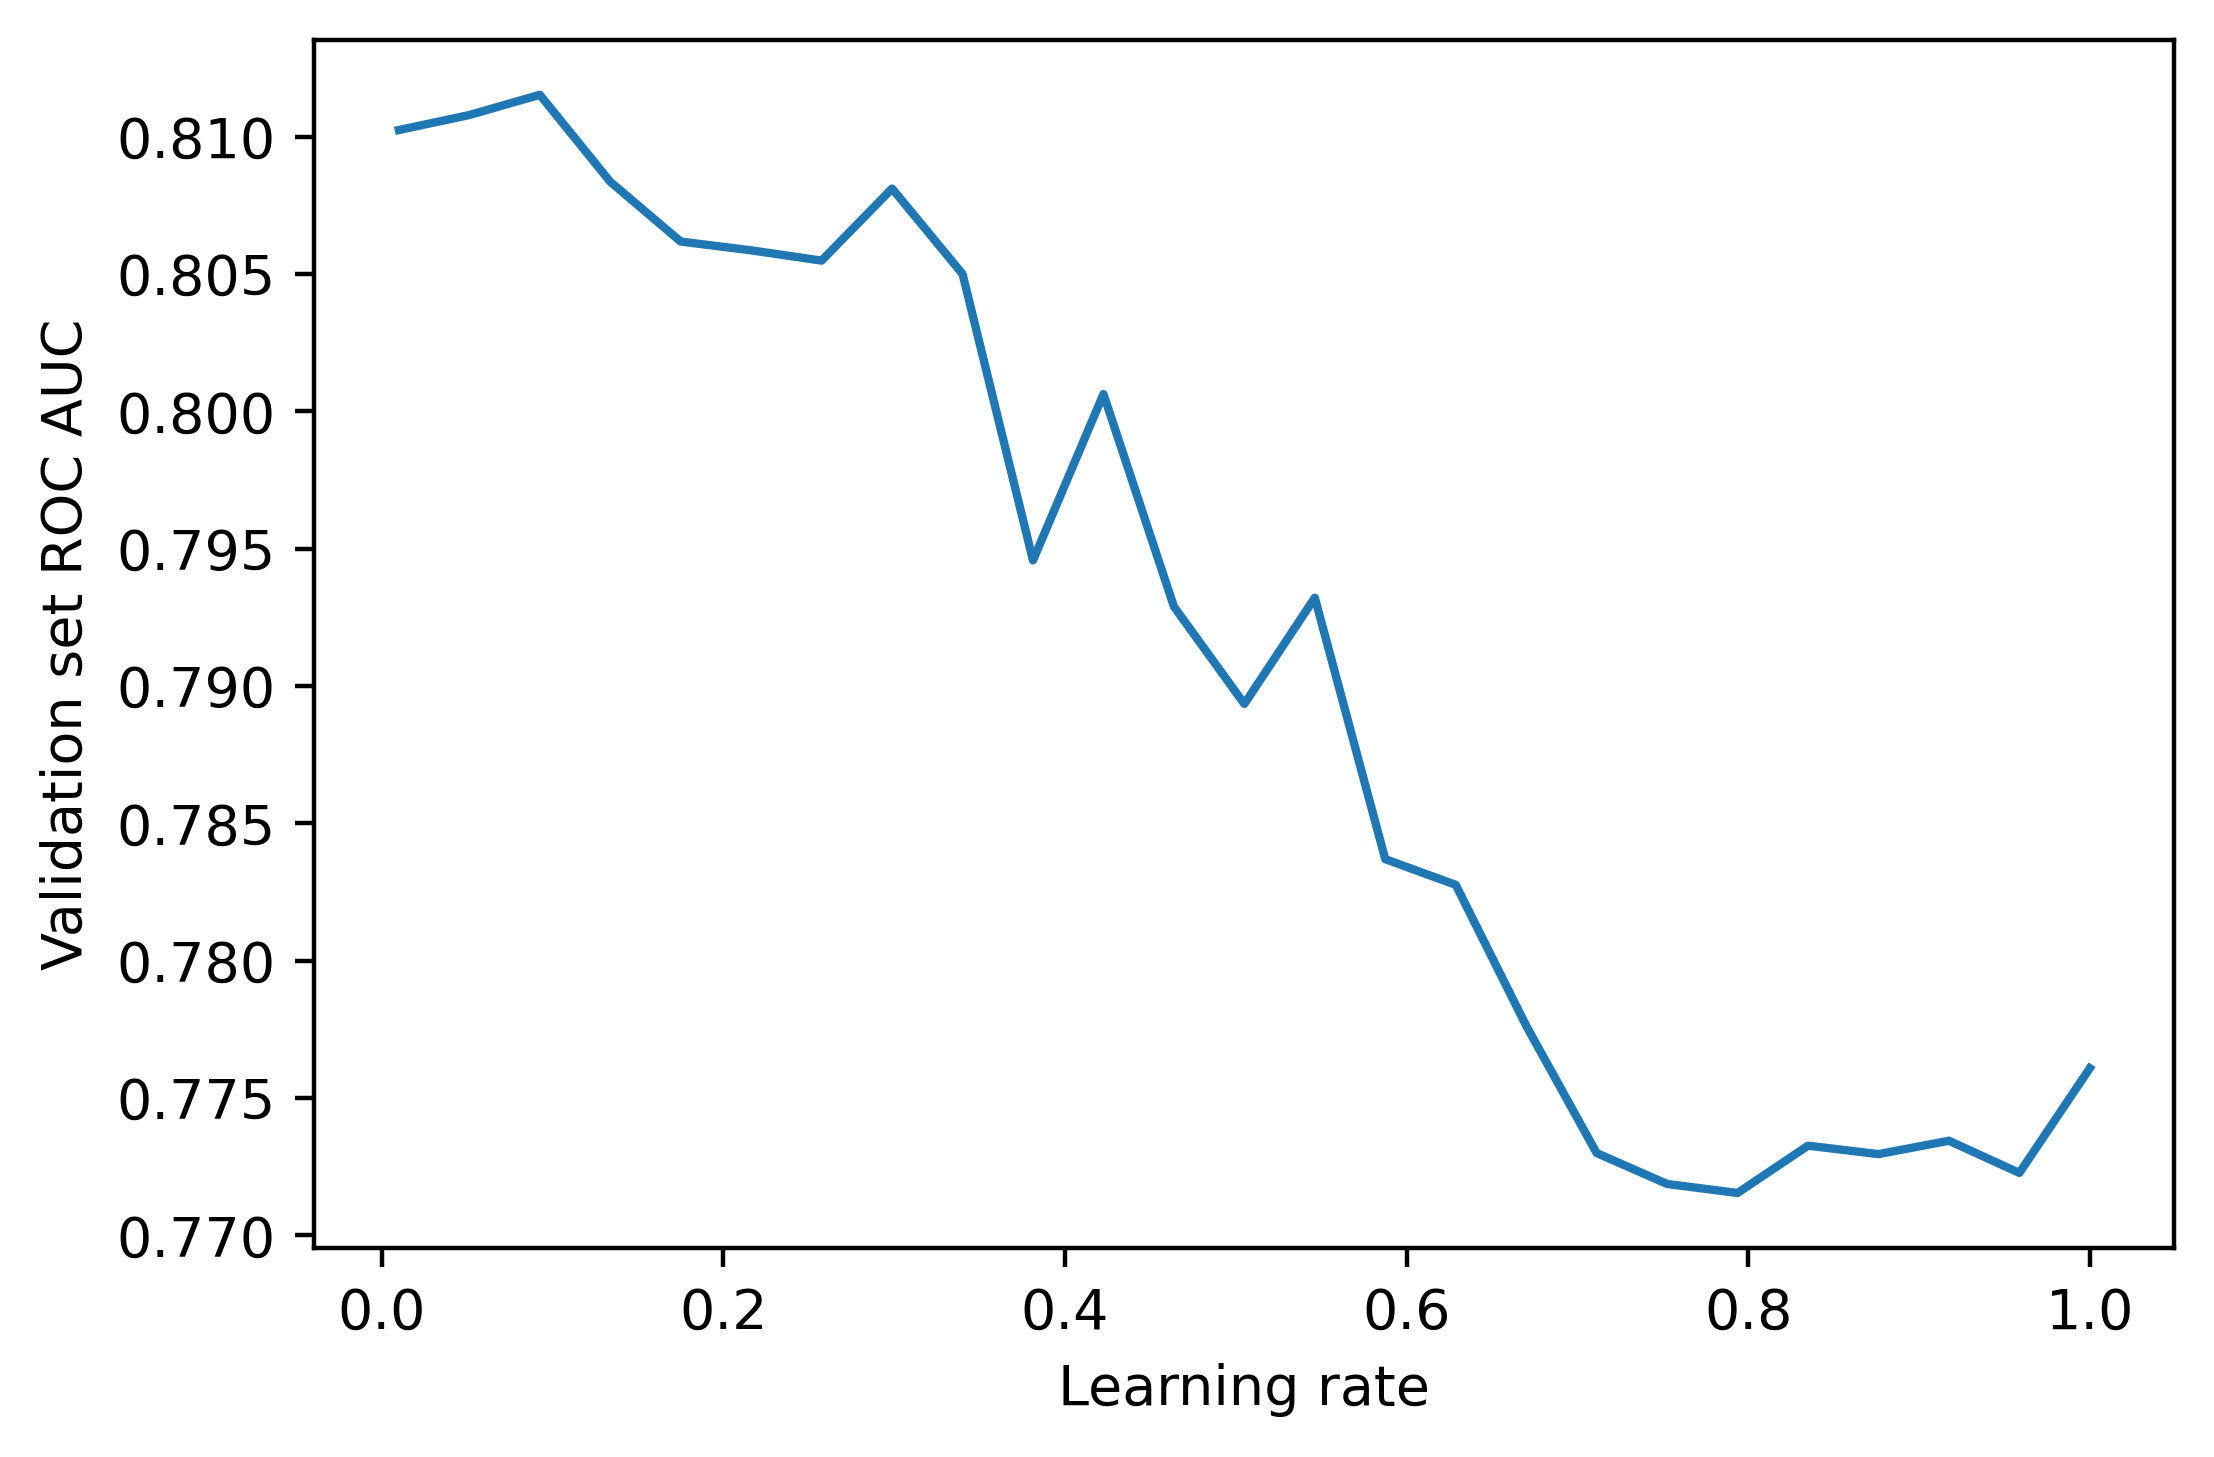

In [14]:
mpl.rcParams['figure.dpi'] = 400
plt.plot(learning_rates, val_aucs)
plt.xlabel('Learning rate')
plt.ylabel('Validation set ROC AUC')

# Exercise XX: Tuning XGBoost hyperparameters

Which ones? Probably max_depth and one or two more. min_child_weight? Or rather maybe do a randomized grid search over a broader range of hyperparameters? That seems like a good plan, to give practice with this method that I referred to earlier, and also demonstrate a range of hyper parameters.

The documentation on parameter tuning lists six specifically, and this seems like as good a set as any to go with (https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html):

>The first way is to directly control model complexity.

>This includes max_depth, min_child_weight and gamma.

>The second way is to add randomness to make training robust to noise.

>This includes subsample and colsample_bytree.

>You can also reduce stepsize eta. 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterSampler.html#sklearn.model_selection.ParameterSampler

In [15]:
from sklearn.model_selection import ParameterSampler
from scipy.stats.distributions import expon
# >>> import numpy as np

In [16]:
from scipy.stats import uniform

Not sure about sensible values for `gamma`.

In [17]:
param_grid = {'max_depth':[2,3,4,5,6,7],
              'gamma':uniform(loc=0.0, scale=3),
              'min_child_weight':list(range(1,151)),
              'colsample_bytree':uniform(loc=0.1, scale=0.9),
              'subsample':uniform(loc=0.5, scale=0.5),
              'learning_rate':uniform(loc=0.01, scale=0.5)}

In [18]:
rng = np.random.RandomState(0)
n_iter=1000
param_list = list(ParameterSampler(param_grid, n_iter=n_iter,
                                   random_state=rng))
#n_iter=300

Looks like this is consistent if the seed is set:

In [19]:
param_list

[{'colsample_bytree': 0.5939321535345923,
  'gamma': 2.1455680991172583,
  'learning_rate': 0.31138168803582195,
  'max_depth': 5,
  'min_child_weight': 104,
  'subsample': 0.7118273996694524},
 {'colsample_bytree': 0.6813047017599905,
  'gamma': 1.3127616337880776,
  'learning_rate': 0.4558865003910399,
  'max_depth': 2,
  'min_child_weight': 141,
  'subsample': 0.6917207594128889},
 {'colsample_bytree': 0.8125525342743981,
  'gamma': 1.5866847592587134,
  'learning_rate': 0.29402228054696616,
  'max_depth': 7,
  'min_child_weight': 26,
  'subsample': 0.5355180290989434},
 {'colsample_bytree': 0.17841636973138664,
  'gamma': 0.06065519232097716,
  'learning_rate': 0.426309922773969,
  'max_depth': 2,
  'min_child_weight': 83,
  'subsample': 0.7368040226368553},
 {'colsample_bytree': 0.8208196767816798,
  'gamma': 1.5614324386536145,
  'learning_rate': 0.34943976505948016,
  'max_depth': 2,
  'min_child_weight': 10,
  'subsample': 0.7686866147245053},
 {'colsample_bytree': 0.7827540618

In [20]:
param_list[0]

{'colsample_bytree': 0.5939321535345923,
 'gamma': 2.1455680991172583,
 'learning_rate': 0.31138168803582195,
 'max_depth': 5,
 'min_child_weight': 104,
 'subsample': 0.7118273996694524}

In [21]:
xgb_model_1.set_params(**param_list[0])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5939321535345923,
              gamma=2.1455680991172583, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.31138168803582195,
              max_delta_step=0, max_depth=5, min_child_weight=104, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.7118273996694524,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=1)

In [26]:
%%time
val_aucs = []
train_aucs = []
counter = 1
for params in param_list:
    xgb_model_1.set_params(**params)
    xgb_model_1.fit(X_train, y_train, eval_set=eval_set,
                    eval_metric='auc',
                    verbose=False, early_stopping_rounds=30)
    
    val_set_pred_proba = xgb_model_1.predict_proba(X_val)[:,1]
    val_aucs.append(roc_auc_score(y_val, val_set_pred_proba))
    
    train_set_pred_proba = xgb_model_1.predict_proba(X_train)[:,1]
    train_aucs.append(roc_auc_score(y_train, train_set_pred_proba))
    
    if counter % 50 == 0:
        print('Done with {counter} of {n_iter}'.format(
            counter=counter, n_iter=n_iter))
    counter += 1

Done with 10 of 1000
Done with 20 of 1000
Done with 30 of 1000
Done with 40 of 1000
Done with 50 of 1000
Done with 60 of 1000
Done with 70 of 1000
Done with 80 of 1000
Done with 90 of 1000
Done with 100 of 1000
Done with 110 of 1000
Done with 120 of 1000
Done with 130 of 1000
Done with 140 of 1000
Done with 150 of 1000
Done with 160 of 1000
Done with 170 of 1000
Done with 180 of 1000
Done with 190 of 1000
Done with 200 of 1000
Done with 210 of 1000
Done with 220 of 1000
Done with 230 of 1000
Done with 240 of 1000
Done with 250 of 1000
Done with 260 of 1000
Done with 270 of 1000
Done with 280 of 1000
Done with 290 of 1000
Done with 300 of 1000
Done with 310 of 1000
Done with 320 of 1000
Done with 330 of 1000
Done with 340 of 1000
Done with 350 of 1000
Done with 360 of 1000
Done with 370 of 1000
Done with 380 of 1000
Done with 390 of 1000
Done with 400 of 1000
Done with 410 of 1000
Done with 420 of 1000
Done with 430 of 1000
Done with 440 of 1000
Done with 450 of 1000
Done with 460 of 10

In [27]:
xgb_param_search_df = pd.DataFrame(param_list)

In [28]:
xgb_param_search_df.head()

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample
0,0.593932,2.145568,0.311382,5,104,0.711827
1,0.681305,1.312762,0.455887,2,141,0.691721
2,0.812553,1.586685,0.294022,7,26,0.535518
3,0.178416,0.060655,0.426310,2,83,0.736804
4,0.820820,1.561432,0.349440,2,10,0.768687


In [29]:
xgb_param_search_df['Training ROC AUC'] = train_aucs
xgb_param_search_df['Validation ROC AUC'] = val_aucs

In [30]:
xgb_param_search_df['Validation ROC AUC'].max()
# 0.8151220995602575

0.8151220995602575

Regression lines might be better here than groupby/mean.

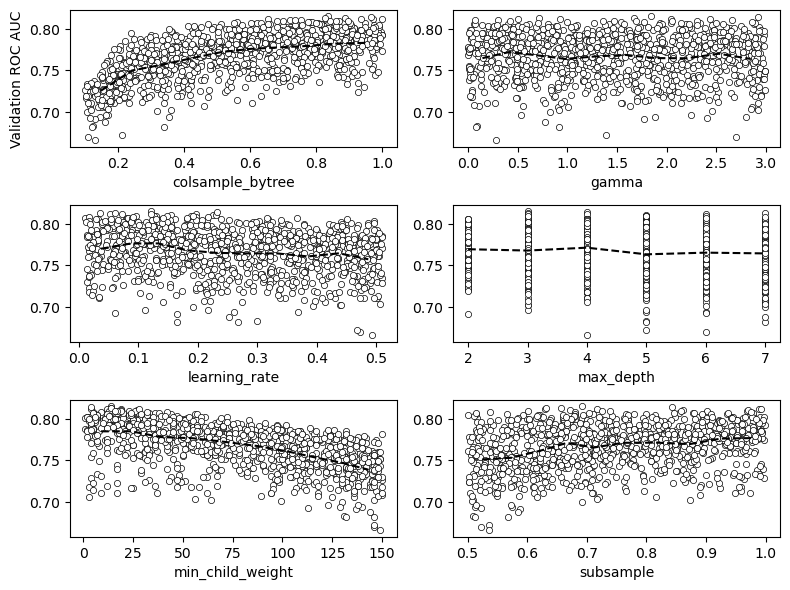

In [31]:
mpl.rcParams['figure.dpi'] = 100
fig, axs = plt.subplots(3,2,figsize=(8,6))
counter = 0
for col in xgb_param_search_df.columns[:-2]:
#     print(col)
    this_ax = axs.flatten()[counter]
    xgb_param_search_df.plot.scatter(
        x=col, y='Validation ROC AUC',
        ax=this_ax, marker='o',
        color='w',
        edgecolor='k',
        linewidth=0.5)
    
    if counter > 0:
        this_ax.set_ylabel('')
    counter += 1
    
    if col != 'max_depth':
        out, bins = pd.qcut(xgb_param_search_df[col], q=10, retbins=True, duplicates='drop')
        half_points = [(bins[ix] + bins[ix+1])/2 for ix in range(len(bins)-1)]
    else:
        out = xgb_param_search_df[col]
        half_points = np.sort(xgb_param_search_df[col].unique())
        
    tmp_df = xgb_param_search_df.copy()
    tmp_df['param_decile'] = out
    mean_df = tmp_df.groupby('param_decile').agg({'Validation ROC AUC':'mean'})
    
    this_ax.plot(half_points, mean_df.values, color='k', linestyle='--')
plt.tight_layout()

This seems like a good illustration of the effects of these hyperparameters, even if there is minimal improvement from tuning them, at least on these synthetic data.

***Show the best hyperparameter combo***

# loss-guide tree growing

So I can use this to generate a random sample over a parameter grid, which I can then loop over with the train/val set I've got. This way I can use early stopping together with this. A next level here would be to do k-fold cv on top of all this, but I think I can refer the interested reader to try and implement if they are interested.

In [19]:
# xgb_model = xgb.XGBClassifier(
#     n_estimators=1000,
#     max_depth=3,
#     learning_rate=0.01,
#     verbosity=1,
#     objective='binary:logistic',
#     use_label_encoder=False,
#     n_jobs=-1,
#     min_child_weight=100)
# params = {'max_depth':[6],
#           'n_estimators':[1000],
#           'colsample_bytree':[0.9],
#           'subsample':[0.9]}
# #Above can beat the RF in the 4-fold CV
# # 0.777226

xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=0,
    max_leaves=50,
    learning_rate=0.01,
    verbosity=1,
    objective='binary:logistic',
    use_label_encoder=False,
    n_jobs=-1,
    min_child_weight=100,
    tree_method='hist',
    grow_policy='lossguide')
params = {'n_estimators':[1000],
          'colsample_bytree':[0.9],
          'subsample':[0.9]}
# 0.777415 so comparable, and works a lot faster than the above



In [52]:
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=3,
    learning_rate=0.01,
    verbosity=1,
    objective='binary:logistic',
    use_label_encoder=False,
    n_jobs=-1,
    min_child_weight=100)
params = {'max_depth':[6],
          'n_estimators':[1000],
          'colsample_bytree':[0.9],
          'subsample':[0.9]}
#Above can beat the RF in the 4-fold CV
# 0.777226



Shaps

In [49]:
%time explainer = shap.TreeExplainer(xgb_model)

CPU times: user 137 ms, sys: 3.89 ms, total: 141 ms
Wall time: 145 ms


In [50]:
%time shap_values = explainer.shap_values(X_val)

CPU times: user 1.36 s, sys: 5.36 ms, total: 1.37 s
Wall time: 383 ms


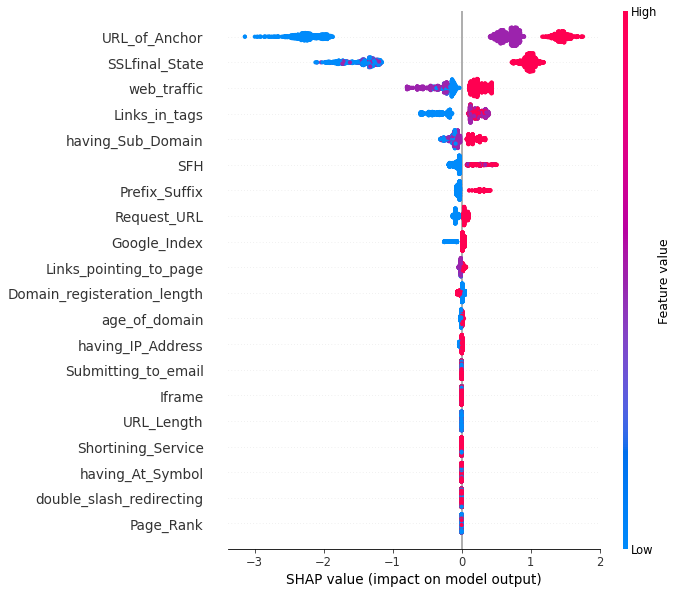

CPU times: user 965 ms, sys: 63.5 ms, total: 1.03 s
Wall time: 974 ms


In [51]:
%%time
mpl.rcParams['figure.dpi'] = 75
shap.summary_plot(shap_values, X_val)

So, after needing to find another dataset from the UCI, since the first one apparently doesn't result in interesting XGBoost training, I have this one. It's not really business-related necessary, more like security related. But I suppose it's of general interest I guess?

The potential drawbacks here are that it's very easy to predict (AUC around 0.97 or 0.98) and the loss-guide may not out-perform the depth-wise strategy, like it may with the case study data.

All in all I guess it's acceptable, although it would have been nice to find a more human-behavior and business-relevant dataset.

Anyways what do I need to do here?
Probably want to do hyperparameter tuning for the depthwise and lossguide strategies. I think a good step here would be to do a little web "lit review" on which are the most important hyperparameters to tune:
- XGBoost docs have a page on this, I think
- I know there are others
- Maybe make a spreadsheet indicating which ones are mentioned in which guides

Go from there. Then I could more confidently make statements like "these are some of the most important hyperparameters to tune" as I'm probably not going to exhaustively list and test all of them for XGBoost.